In [2]:
library(Seurat)
library(data.table)
library(Matrix)
library(future)
library(dplyr)
library(tidyr)
library(patchwork)
library(ggplot2)
library(ggrepel)
library(grid)
library(Matrix)
library(doParallel)
library(FNN)
library(edgeR)
library(harmony)
library(SeuratDisk)
library(spacexr)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Loading required package: limma

Loading required package: Rcpp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [3]:
options(future.globals.maxSize = 32000 * 1024^2)
plan("multicore", workers = 12)
plan()

multicore:
- args: function (..., workers = 12, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 12)

### Load Seurat

In [4]:
vis.obj <- readRDS("data/visium_all.rds")
vis.obj

An object of class Seurat 
35758 features across 12771 samples within 3 assays 
Active assay: SCT (17800 features, 12000 variable features)
 2 other assays present: Spatial, prediction.score.cell_types_level_3
 6 dimensional reductions calculated: pca, harmony, umap, tsne, ref.pca, ref.umap
 4 images present: A_1, A_2, B_1, B_2

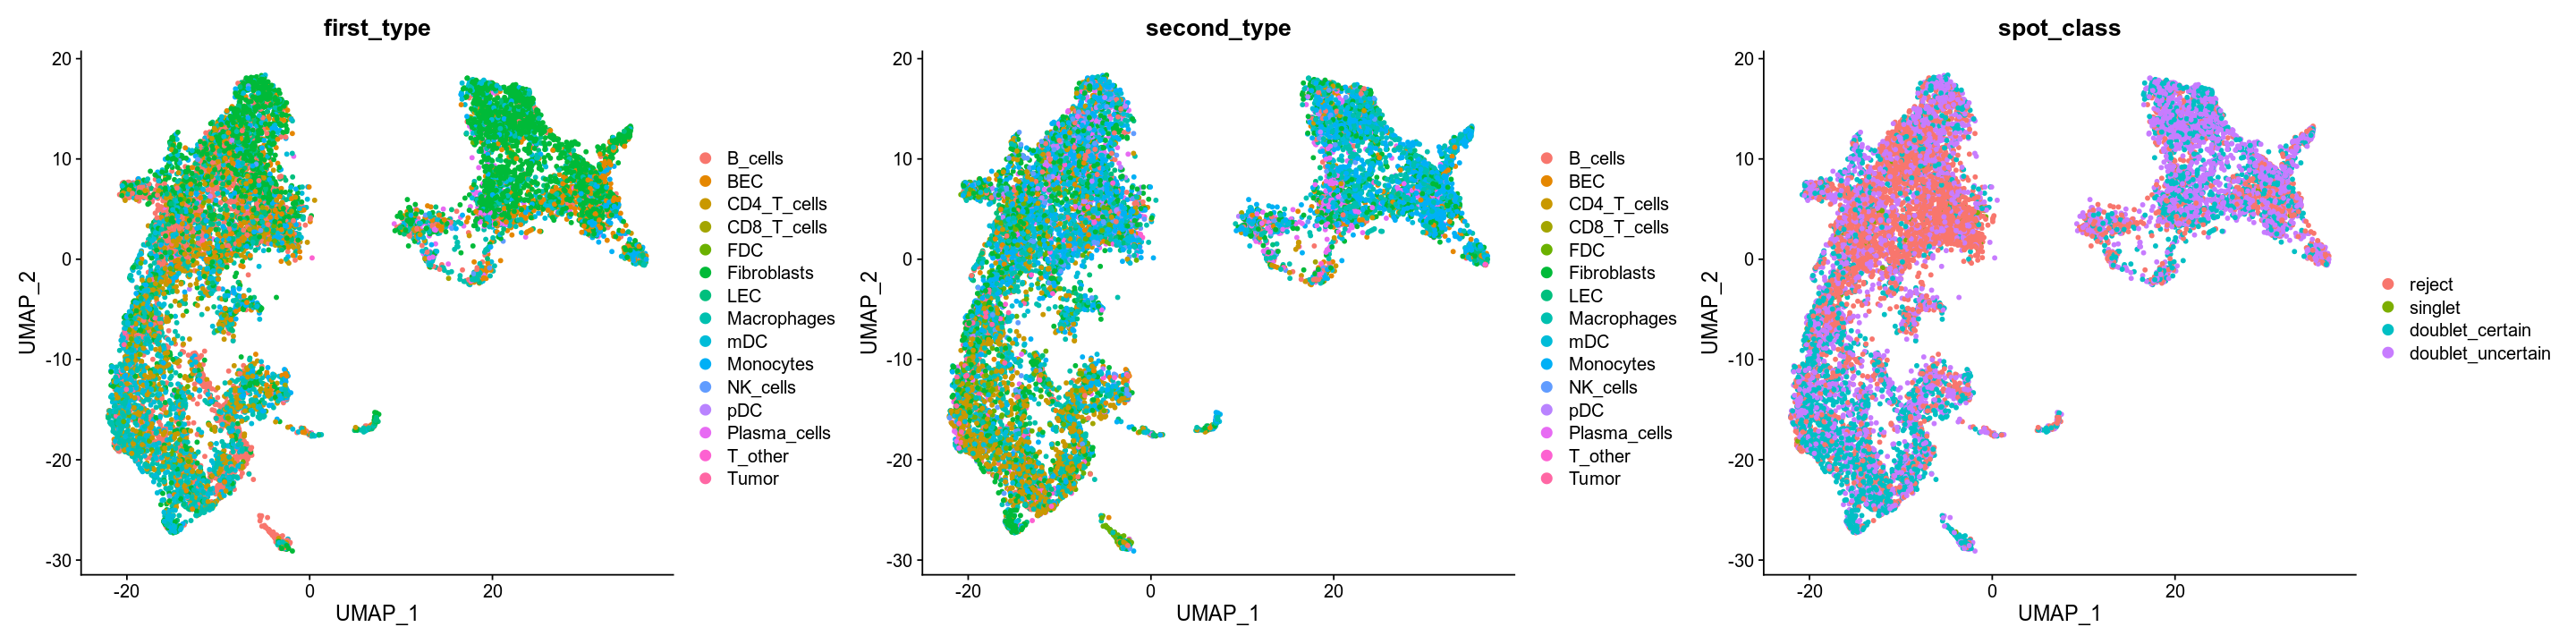

In [185]:
options(repr.plot.width=24, repr.plot.height=6)
DimPlot(vis.obj, reduction = "umap", group.by = c("first_type", "second_type", "spot_class"), pt.size=1)

### Load RCTD

In [ ]:
single_cell_ref <- LoadH5Seurat(
    "~/cHL_singlecell/data/single_cell_objects/combined_dataset_final_annotated_postqc_harmonized1.h5Seurat"
)

In [ ]:
if(!file.exists('data/RCTD_visium_chl_full.rds')) {
    counts <- vis.obj@assays$Spatial@counts
    nUMI <- colSums(counts) 
    puck <- SpatialRNA(NULL, counts, nUMI, use_fake_coords=TRUE)
    barcodes <- colnames(puck@counts)  

    counts <- single_cell_ref@assays$cellbender_corrected@counts
    cell_types <- setNames(single_cell_ref@meta.data$cell_types_level_3, colnames(single_cell_ref))
    cell_types <- as.factor(cell_types)
    nUMI <- colSums(counts)
    rctd.reference <- Reference(counts, cell_types, nUMI)
    myRCTD <- create.RCTD(puck, rctd.reference, UMI_min = 5, UMI_min_sigma = 5, max_cores = 32)
    myRCTD <- run.RCTD(myRCTD, doublet_mode = 'full')
    saveRDS(myRCTD, 'data/RCTD_visium_chl_full.rds')
}

In [175]:
full.RCTD <- readRDS('data/RCTD_visium_chl_full.rds')

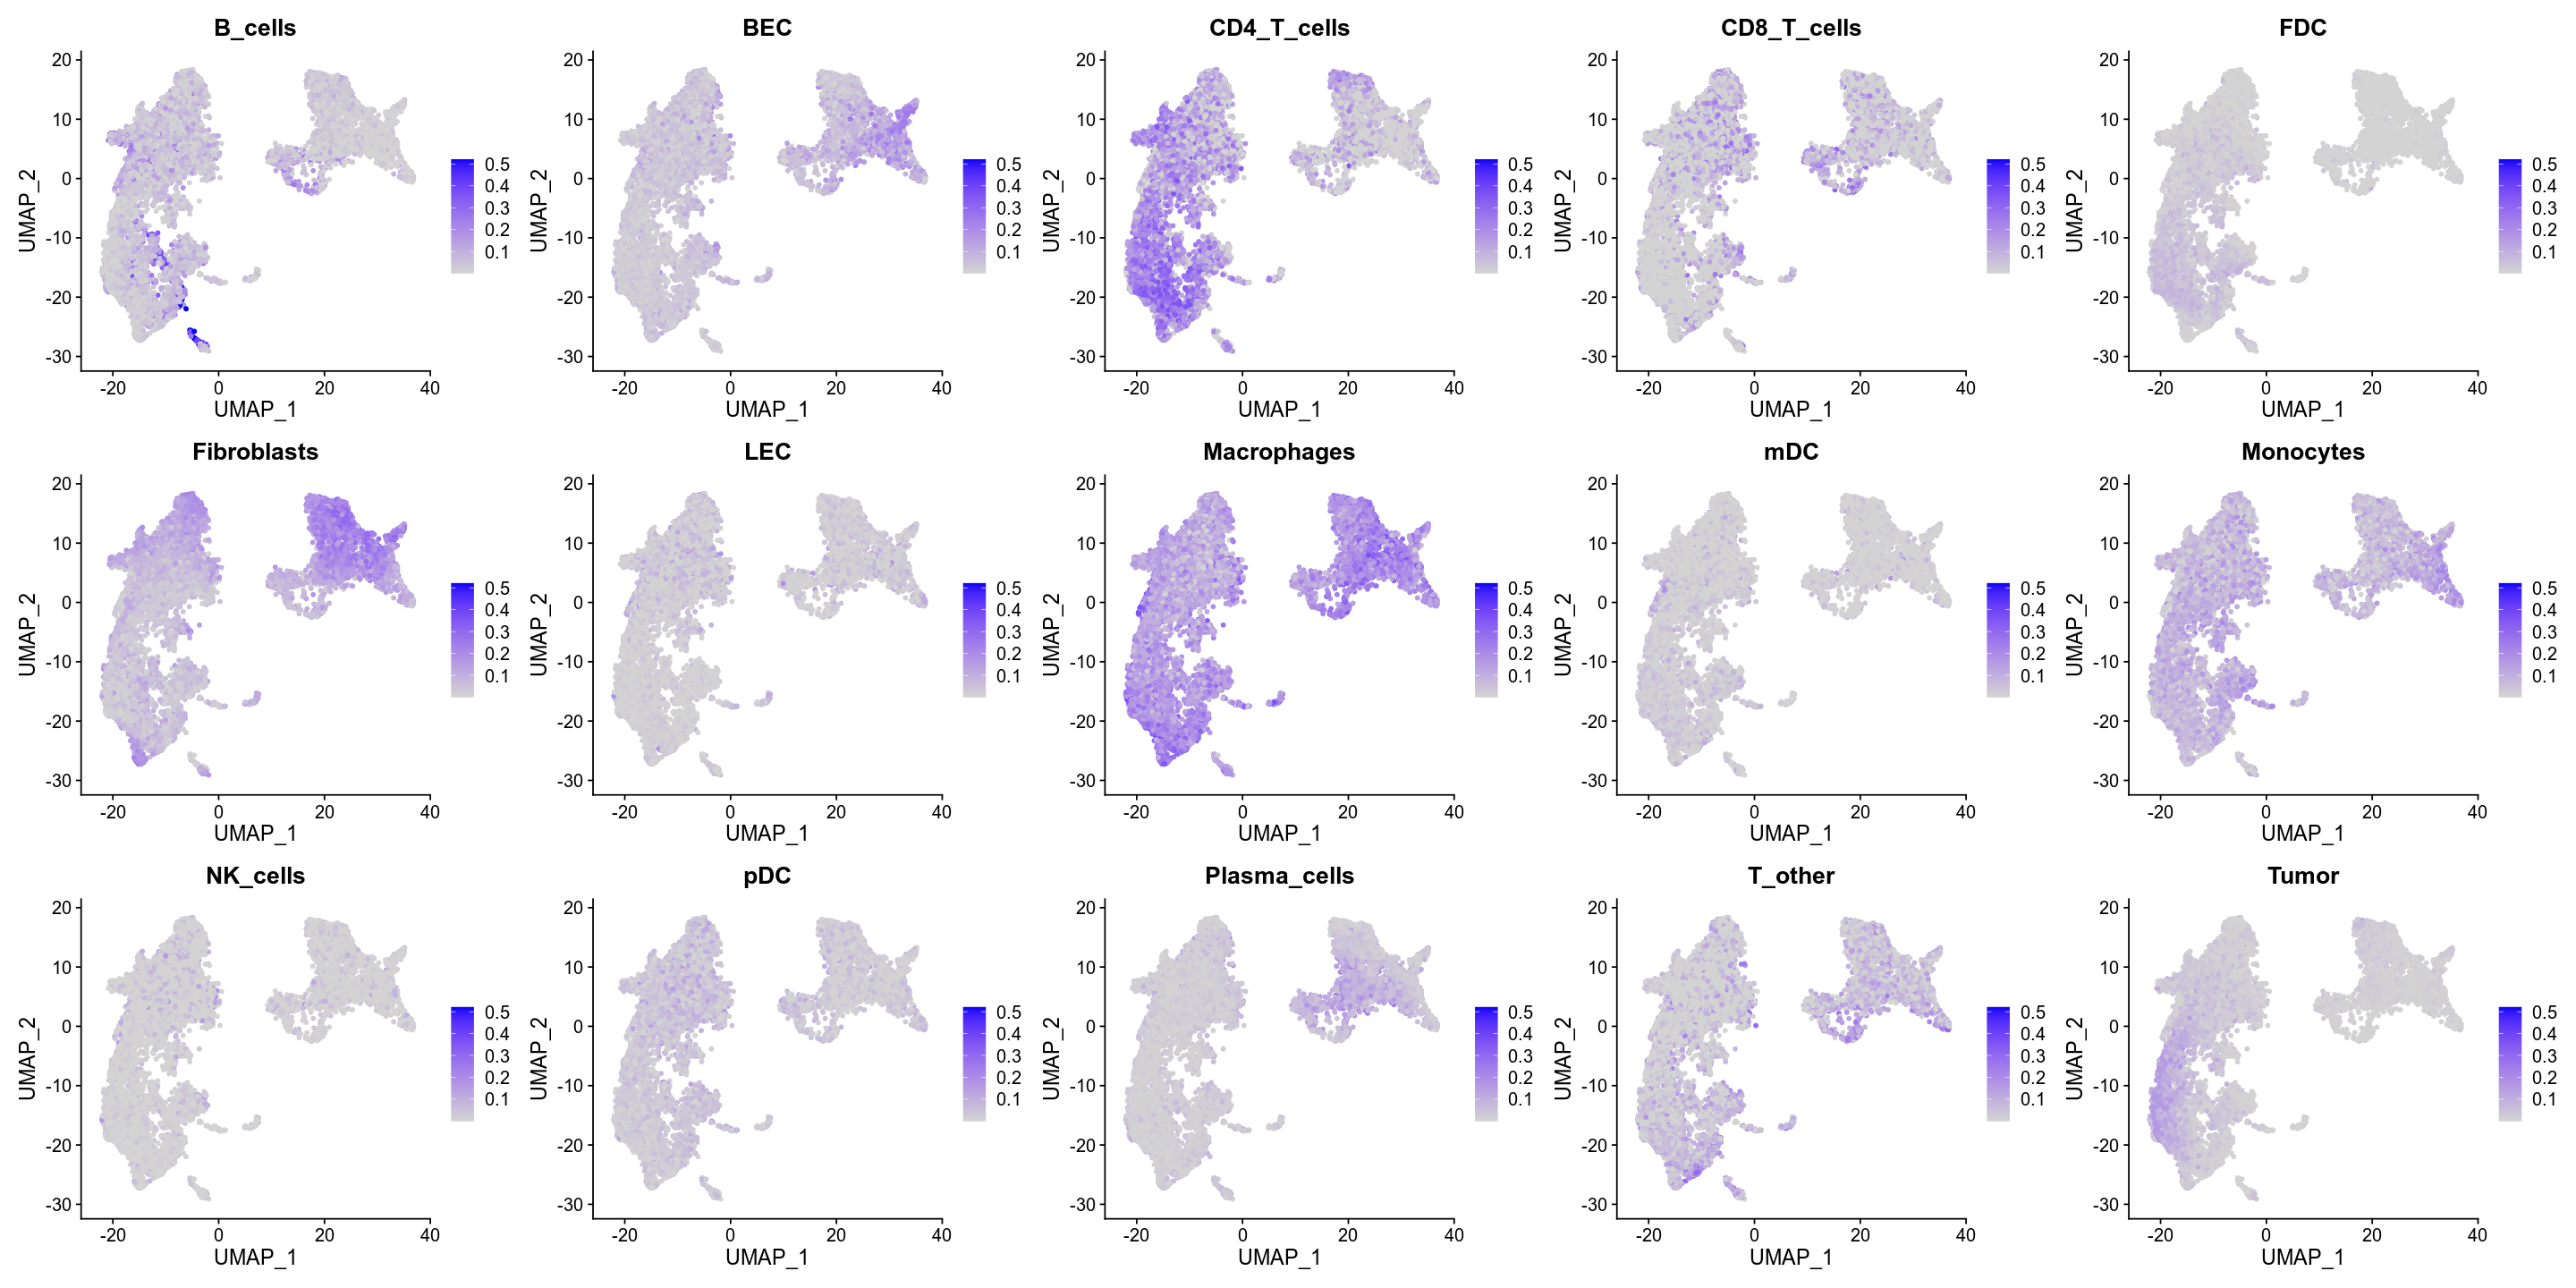

In [235]:
options(repr.plot.width=24, repr.plot.height=12)
FeaturePlot(vis.obj, features = as.data.table(table(vis.obj[['first_type']]))$V1, ncol=5, pt.size=1, keep.scale='all', max.cutoff='q99')

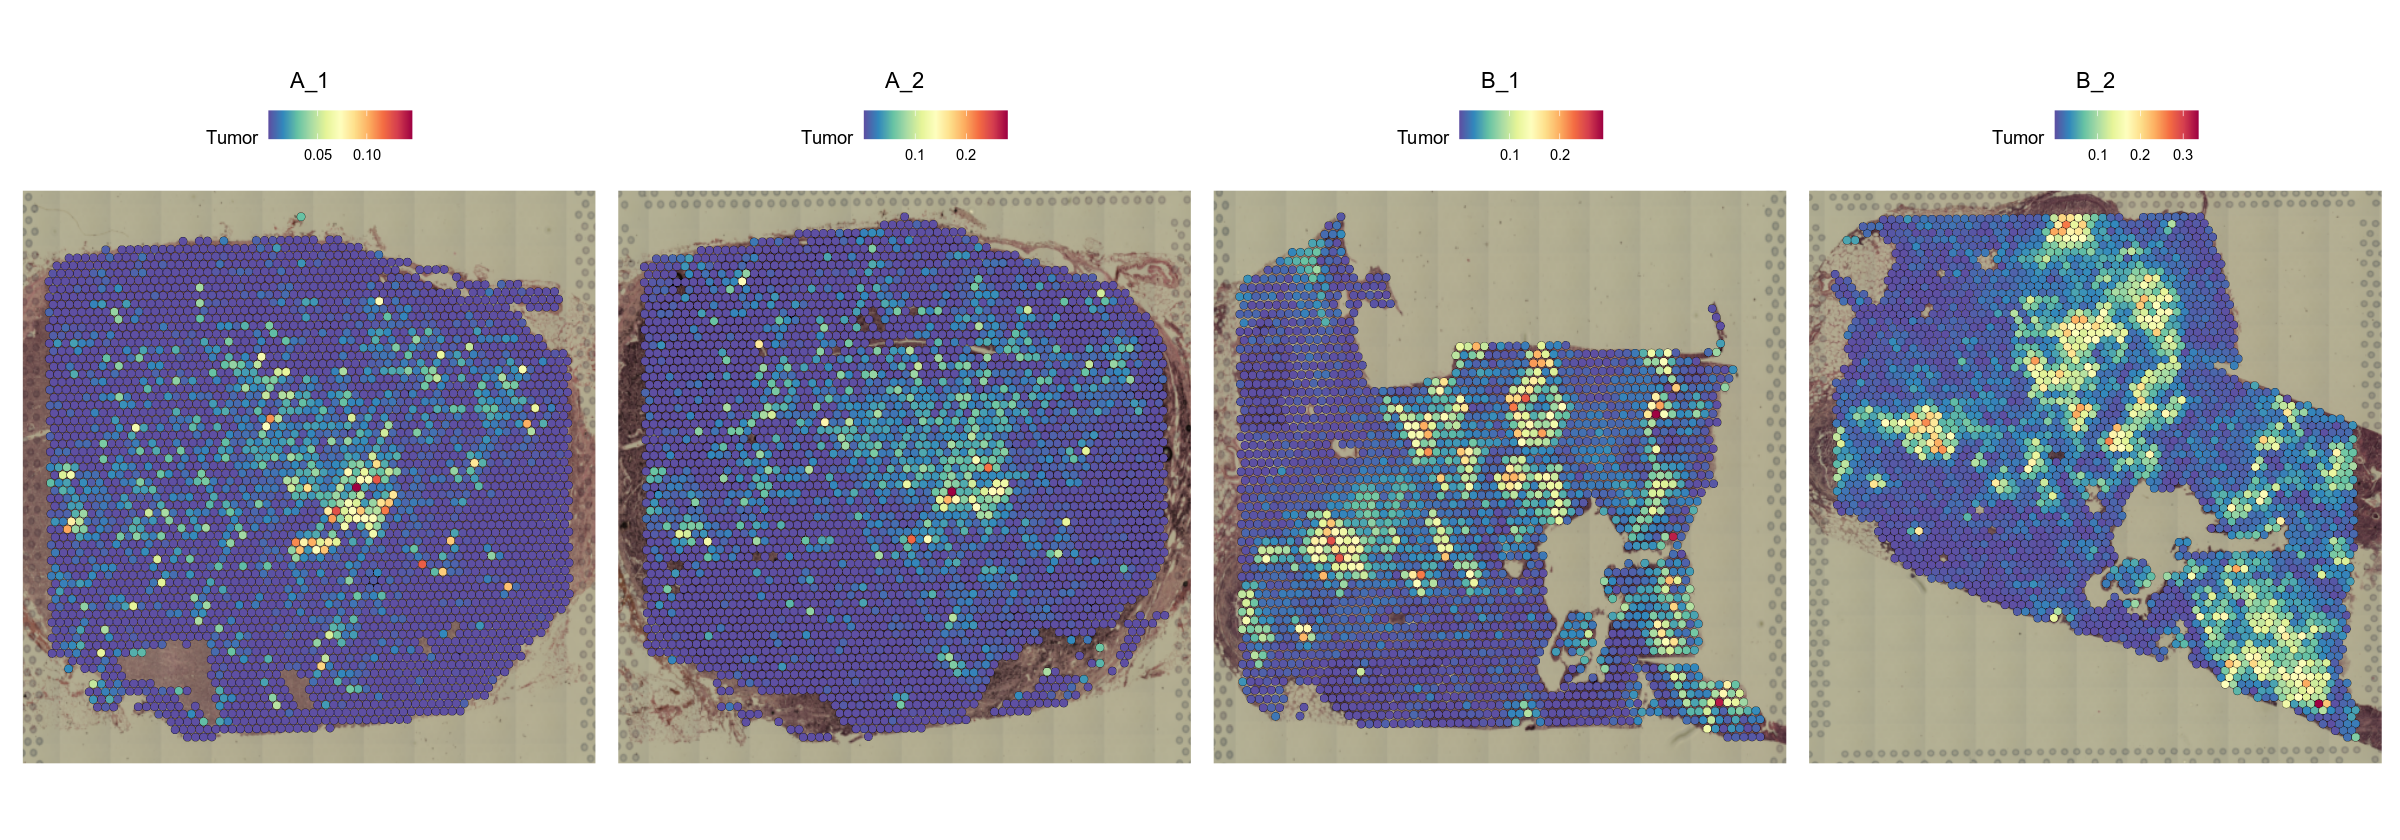

In [244]:
options(repr.plot.width=20, repr.plot.height=7)
SpatialFeaturePlot(vis.obj, ncol=4, features="Tumor")

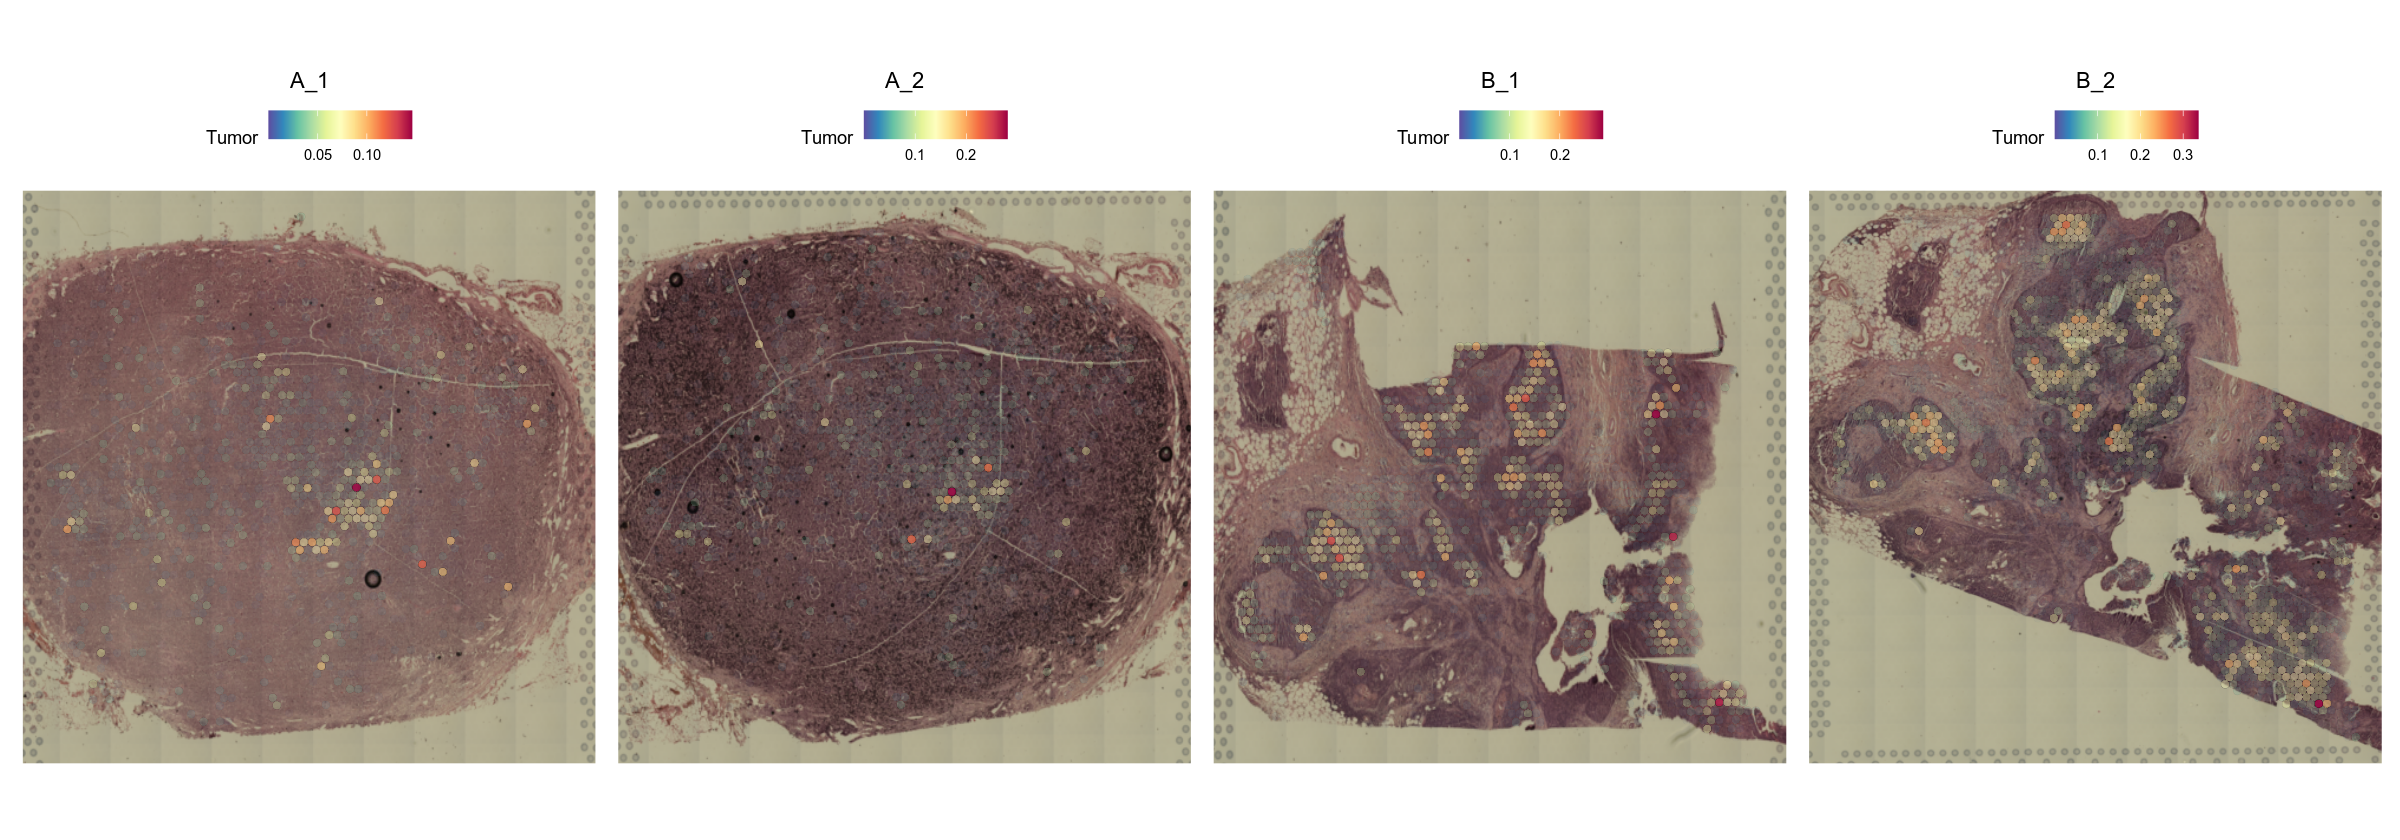

In [277]:
options(repr.plot.width=20, repr.plot.height=7)
SpatialFeaturePlot(vis.obj, ncol=4, features="Tumor", alpha=c(0,0.8))

### Run CSIDE

In [8]:
single_cell_ref <- LoadH5Seurat(
    "~/cHL_singlecell/data/single_cell_objects/combined_dataset_final_annotated_postqc_harmonized1.h5Seurat"
)

Validating h5Seurat file

Initializing cellbender_corrected with data

Adding counts for cellbender_corrected

Adding feature-level metadata for cellbender_corrected

Adding variable feature information for cellbender_corrected

Adding miscellaneous information for cellbender_corrected

Adding reduction harmony

Adding cell embeddings for harmony

Adding feature loadings for harmony

Adding projected loadings for harmony

Adding miscellaneous information for harmony

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [5]:
vis.pucks <- list()
exp.vars <- list()
for (slide in c("A_1", "A_2", "B_1", "B_2")) {
    puck.obj <- subset(vis.obj, orig.ident == slide)
    
    coords <- puck.obj@meta.data[c('imagerow','imagecol')]
    colnames(coords) <- c('x', 'y')
    counts <- puck.obj@assays$Spatial@counts
    nUMI <- colSums(counts) 
    puck <- SpatialRNA(coords, counts, nUMI)
    
    ev <- puck.obj@meta.data$Tumor
    names(ev) <- rownames(puck.obj@meta.data)
    
    vis.pucks[[slide]] <- puck
    exp.vars[[slide]] <- ev
}

In [6]:
saveRDS(exp.vars, 'data/visium_CHL_RCTD_exp_vars.rds')

In [9]:
counts <- single_cell_ref@assays$cellbender_corrected@counts
cell_types <- setNames(single_cell_ref@meta.data$cell_types_level_3, colnames(single_cell_ref))
cell_types <- as.factor(cell_types)
nUMI <- colSums(counts)
rctd.reference <- Reference(counts, cell_types, nUMI)

Warning message in Reference(counts, cell_types, nUMI):
“Reference: number of cells per cell type is 131167, larger than maximum allowable of 10000. Downsampling number of cells to: 10000”


In [ ]:
replicate_names <- c('A_1','A_2','B_1','B_2')
group_ids <- c(1,1,2,2)
RCTD.replicates <- create.RCTD.replicates(
    vis.pucks, rctd.reference, replicate_names, group_ids = group_ids, max_cores = 16
)

In [9]:
RCTD.replicates <- run.RCTD.replicates(RCTD.replicates, doublet_mode = 'full')

run.RCTD.replicates: running RCTD for replicate 1

fitBulk: decomposing bulk

chooseSigma: using initial Q_mat with sigma =  1

Likelihood value: 796997.564269897

Sigma value:  0.84

Likelihood value: 788611.243675012

Sigma value:  0.69

Likelihood value: 782900.104471037

Sigma value:  0.61

Likelihood value: 780867.387880035

Sigma value:  0.53

Likelihood value: 779621.701941953

Sigma value:  0.48

Likelihood value: 779265.472538467

Sigma value:  0.46

Likelihood value: 779220.369407243

Sigma value:  0.45

Likelihood value: 779215.936613107

Sigma value:  0.45

run.RCTD.replicates: running RCTD for replicate 2

fitBulk: decomposing bulk

chooseSigma: using initial Q_mat with sigma =  1

Likelihood value: 795862.860051768

Sigma value:  0.84

Likelihood value: 787572.09701935

Sigma value:  0.69

Likelihood value: 781961.131693569

Sigma value:  0.61

Likelihood value: 779986.006570955

Sigma value:  0.53

Likelihood value: 778802.252891405

Sigma value:  0.48

Likelihood value:

In [10]:
saveRDS(RCTD.replicates, 'data/visium_CHL_RCTD_replicates.rds')

In [22]:
cell_types <- as.character(unique(vis.obj[['first_type']])$first_type)

In [11]:
unique(cell_types)

[1] Tumor        BEC          LEC          Fibroblasts  FDC         
 [6] B_cells      Plasma_cells CD4_T_cells  CD8_T_cells  NK_cells    
[11] T_other      Macrophages  mDC          pDC          Monocytes   
15 Levels: B_cells BEC CD4_T_cells CD8_T_cells FDC Fibroblasts ... Tumor

In [ ]:
visium_CHL_RCTD_exvar_Tumor_low_gene_threshold <- run.CSIDE.replicates(
    RCTD.replicates = RCTD.replicates,
    explanatory.variable.replicates = exp.vars,
    cell_types = cell_types,
    population_de = F,
    doublet_mode = F,
    gene_threshold = 1e-06,
    cell_type_threshold = 0
)

run.CSIDE.replicates: running CSIDE for replicate 1

run.CSIDE.general: running CSIDE with cell types B_cells, BEC, Plasma_cells, Fibroblasts, mDC, LEC, Macrophages, CD4_T_cells, FDC, Monocytes, NK_cells, T_other, CD8_T_cells, pDC, Tumor

run.CSIDE.general: configure params_to_test = 2, 

filter_genes: filtering genes based on threshold = 1e-06



In [ ]:
saveRDS(
    visium_CHL_RCTD_exvar_Tumor_low_gene_threshold, 
    'data/visium_CHL_RCTD_exvar_Tumor_low_gene_threshold.rds'
)

In [ ]:
visium_CHL_RCTD_exvar_Tumor_low_gene_threshold <- CSIDE.population.inference(
    visium_CHL_RCTD_exvar_Tumor_low_gene_threshold,
    use.groups = TRUE,
    MIN.CONV.GROUPS = 2,
    log_fc_thresh = 0.5*log(2),
    q_thresh = 0.05,
    CT.PROP = 0.25
)

In [ ]:
saveRDS(
    visium_CHL_RCTD_exvar_Tumor_low_gene_threshold, 
    'data/visium_CHL_RCTD_exvar_Tumor_low_gene_threshold.rds'
)

In [ ]:
save.CSIDE.replicates(
    visium_CHL_RCTD_exvar_Tumor_low_gene_threshold,
    'data/population_groups_min3')

In [12]:
RCTD.replicates <- readRDS('data/visium_CHL_RCTD_replicates.rds')
exp.vars <- readRDS('data/visium_CHL_RCTD_exp_vars.rds')
replicate_names <- c('A_1','A_2','B_1','B_2')
group_ids <- c(1,1,2,2)
cell_types <- c('Tumor','BEC','LEC','Fibroblasts','FDC','B_cells','Plasma_cells',
                'CD4_T_cells','CD8_T_cells','NK_cells','T_other','Macrophages','mDC','pDC','Monocytes')

visium_CHL_RCTD_exvar_Tumor_low_gene_threshold <- run.CSIDE.replicates(
    RCTD.replicates = RCTD.replicates,
    explanatory.variable.replicates = exp.vars,
    cell_types = cell_types,
    population_de = F,
    doublet_mode = F,
    gene_threshold = 1e-06,
    cell_type_threshold = 0
)

run.CSIDE.replicates: running CSIDE for replicate 1

run.CSIDE.general: running CSIDE with cell types Tumor, BEC, LEC, Fibroblasts, FDC, B_cells, Plasma_cells, CD4_T_cells, CD8_T_cells, NK_cells, T_other, Macrophages, mDC, pDC, Monocytes

run.CSIDE.general: configure params_to_test = 2, 

filter_genes: filtering genes based on threshold = 1e-06



### Save

In [29]:
vis.obj <- AddMetaData(
    vis.obj, 
    metadata = rbind(
        vis.obj@images$A_1@coordinates,
        vis.obj@images$A_2@coordinates,
        vis.obj@images$B_1@coordinates,
        vis.obj@images$B_2@coordinates
    )
)

In [ ]:
saveRDS(vis.obj, "data/visium_all.rds")
SaveH5Seurat(vis.obj, "data/visium_all.h5Seurat", overwrite = TRUE)

In [ ]:
Convert("data/visium_all.h5Seurat", dest = "h5ad", overwrite=TRUE)

In [242]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /home/dchafamo/anaconda3/envs/muscat2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] spacexr_2.0.7         SeuratDisk_0.0.0.9020 harmony_0.1.1        
 [4] Rcpp_1.0.9            edgeR_3.36.0          limma_3.50.3         
 [7] FNN_1.1.3.1           doParallel_1.0.17     iterators_1.0.14     
[10] foreach_1.5.2         ggrepel_0.9.2         ggplot2_3.4.0        
[13] patchwork_1.1.2       tidyr_1.2.1  